Applying a deep and wide neural network, LinUCB, and a combination of the two to a generated dataset.

(DRAFT)

# Import libraries

In [56]:
import torch
import torch.nn as nn
import numpy as np
import pickle

# Import libraries
import random
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

#!pip install space-bandits
from space_bandits import load_model, BanditAlgorithm

import sys

from contextual_dataset_wu import ContextualDataset

# Set parameters

In [59]:
actions = 3 # number of possible actions (arms)
customers = 10000 # number of choices made in 1 simulation
confidence = 0.95 # confidence level
distributions = 2 # number of reward distributions per action (customer groups)

## path to the contextual_dataset_wu.py and toy_problem_wu.py files
path = '/home/aleksey/Desktop/FellowshipAI/deep-and-wide-bandit-dev_012621/TestDeepWide/'
sys.path.append(path)

alpha = 1. + np.sqrt(0.5*np.log(2./(1. - confidence)))

# Generate dataset

Two groups of customers with different preferences:
* Group 1: 20 customers, IDs 0-19; mean age 25, stdev 5 years, min age 18; mean ARPU 100, stdev 15.
* Group 2: 20 customers, IDs 20-39; mean age 45, stdev 6 years; mean ARPU 50, stdev 25.

Three possible actions:
* Gaussian distribution of rewards for each action;
* Means randomly sampled from a uniform distribution between -1 and 1;
* Standard deviations randomly sampled from a uniform distribution between 0 and 1;
* Different reward distributions for customers in different groups (top panel - group 1; bottom pannel - group 2).


In [3]:
# Copied from space-bandits
def get_customer(ctype=None):
    """Customers come from two feature distributions.
    Class 1: mean age 25, stdev 5 years, min age 18
             mean ARPU 100, stdev 15
    Class 2: mean age 45, stdev 6 years
             mean ARPU 50, stdev 25
    """
    if ctype is None:
        if random.random() > .5: #coin toss
            ctype = 1
        else:
            ctype = 2
    age = 0
    ft = -1
    if ctype == 1:
        while age < 18:
            age = np.random.normal(25, 5)
        while ft < 0:
            ft = np.random.normal(100, 15)
        user_id = np.random.randint(0,19)

    if ctype == 2:
        while age < 18:
            age = np.random.normal(45, 6)
        while ft < 0:
            ft = np.random.normal(50, 25)
        user_id = np.random.randint(20,39)

    age = round(age)
    return ctype, (age, ft), user_id

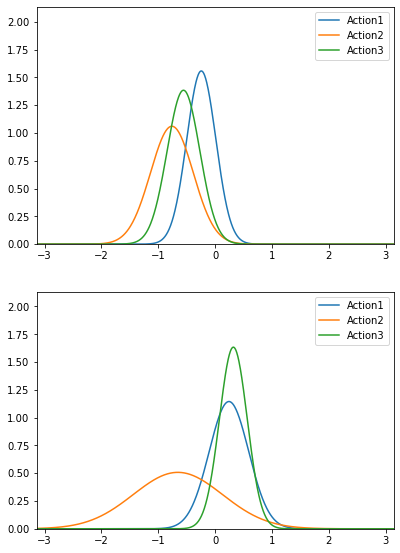

In [4]:
# Generate training and validation datasets:
# -- context: 2 features, age and ARPU
# -- reward: real number
# -- two types of customers differ in age and ARPU

# Set up distributions of rewards:
# normal, with randomly selected mean and variance for each action and customer type

# mean rewards for each of the possible actions and each of the 2 customer types
mean = [[2*(random.random()-0.5) for i in range(actions)] for j in range(distributions)]
# standard deviations of rewards for each of the possible actions and each of the 2 customer types
stdev = [[random.random() for i in range(actions)] for j in range(distributions)]

# find ranges for x and y values
min_sigma = 1.E5
max_sigma = 0.
for i in range(distributions):
    if max(stdev[i]) > max_sigma:
        max_sigma = max(stdev[i])
    if min(stdev[i]) < min_sigma:
        min_sigma = min(stdev[i])
xlimit = 4*max_sigma
ylimit = stats.norm.pdf(0,0,min_sigma)+0.5

# plot distributions of rewards: separate panel for each of the 2 customer types
fig, axs = plt.subplots(distributions, figsize=(6.4, 4.8*distributions))
plt.setp(axs, xlim=(-xlimit,xlimit), ylim=(0,ylimit))
for distribution in range(distributions):
    for action in range(actions):
        mu = mean[distribution][action]
        sigma = stdev[distribution][action]
        x = np.linspace(-xlimit, +xlimit, 1000)
        axs[distribution].plot(x, stats.norm.pdf(x, mu, sigma), label="Action"+str(action+1))
    axs[distribution].legend()

In [5]:
# Generate customer dataset

ages = [] # customer ages
ARPUs = [] # customer ARPUs
actions_taken = [] # actions taken by customers
rewards_received = [] # rewards received by customers
user_ids = [] # customer user IDs

contexts = [] # contexts provided for each customer
              # a context is a numpy array with dimensions (context_dim, 1) (column vectors)
rewards = []  # rewards that would have been received by each customer for each possible action
              # possible rewards are numpy arrays with dimensions (actions,)

cust = get_customer()
context_dim = len(cust[1]) # dimensions of the context

for customer in range(customers):
    cust = get_customer() 
    customer_type = cust[0] - 1 # customer type
    contexts.append( np.asarray(cust[1]).reshape((context_dim, 1)) ) # add context for customer to dataset
    # possible rewards for each customer are randomly sampled from the distributions
    # for each of the possible actions for the given customer type
    possible_rewards = np.zeros(actions)
    sampled_rewards = np.zeros(actions)
    for action in range(actions):
        mu = mean[customer_type][action]
        sigma = stdev[customer_type][action]
        possible_rewards[action] = np.random.normal(mu, sigma)
        sampled_rewards[action] = np.random.normal(mu, sigma)
        
    rewards.append(possible_rewards) # add rewards received to dataset
    
    ages.append(cust[1][0])
    ARPUs.append(cust[1][1])
    user_ids.append(cust[2])
    rewards_received.append(possible_rewards[np.argmax(sampled_rewards)])
    actions_taken.append(np.argmax(sampled_rewards))

In [7]:
df = pd.DataFrame()
df['age'] = ages
df['ARPU'] = ARPUs
df['action'] = actions_taken
df['reward'] = rewards_received
df['user_id'] = user_ids
df.head()

,age,ARPU,action,reward,user_id
0,29,91.655001,0,-0.050608,16
1,22,78.914243,0,-0.079528,10
2,26,112.054985,1,-1.252204,2
3,39,104.126961,1,-1.211401,12
4,22,102.520756,0,0.041536,12


# LinUCB class definition

In [8]:
# LinUCB class required parameters:
# -- actions - number of possible actions: integer
# -- contexts - contexts for each step: list of column vectors, np arrays with dimensions (num features, 1)
# -- rewards - possible rewards for each step: list of np arrays with dimensions (actions,) (offline)
# -- offline - regime: boolean, True - offline, False - online (currently offline only)

# LinUCB weights (optional), will be initialized automatically, unless specified:
# -- A - list of length actions, list elements are square np arrays of size (num features, num features)
# -- b - list of length actions, list elements are column vectors, np arrays with dimensions (num features, 1)

class LinUCB:
    
    def __init__(self, actions, contexts, rewards, offline, A=None, b=None):

        # Inputs (see above)
        
        if isinstance(actions, int) == True:
            self.actions = actions
        else:
            raise ValueError("The number of possible actions must be an integer!\n")
            
        try:
            if len(contexts) == len(rewards) and rewards[0].shape == (self.actions,):
                self.contexts = contexts
                self.rewards = rewards
            elif len(contexts) != len(rewards):
                raise ValueError("The number of contexts and rewards must be the same!\n")
            else:
                raise ValueError("Rewards for all possible actions must be specified!\n")
        except:
            raise ValueError("Wrong format for contexts or rewards!\n")
        
        if isinstance(offline, bool) == True:
            self.offline = offline
        else:
            raise ValueError("offline must have a bool value!\n")
        
        # Parameters (see above)
        
        self.context_dim = self.contexts[0].shape[0] # number of features in context
        
        if (A == None) or (b == None): # initialize LinUCB parameters A and b if not provided
            self.A = [np.identity(self.context_dim) for action in range(self.actions)]
            self.b = [np.zeros((self.context_dim,1)) for action in range(self.actions)]
        else: # check that provided A and b parameters are in the right format
            try:
                if len(A) == len(b) == self.actions and A[0].shape == (self.context_dim, self.context_dim) and b[0].shape == (self.context_dim,1):
                    self.A = A
                    self.b = b
                else:
                    raise ValueError("Wrong format for A or b parameters!\n")
            except:
                raise ValueError("Wrong format for A or b parameters!\n")

        
        # Outputs
        
        self.total_rewards = [0.] # Total rewards for each step

        # The following metrics are only meaningful in offline mode (lists with a single 0. in online mode)
        self.max_total_rewards = [0.] # Total rewards for each step when always choosing action with highest mean reward
        self.random_total_rewards = [0.] # Total rewards for each step when randomly selecting an action
        

    # Select an action for the provided context using LinUCB algorithm
    # -- context is a single column vector, np array with dimensions (num features, 1)
    def get_action(self, context):

        p = [0 for action in range(self.actions)]
        for action in range(self.actions):
            A_inv = np.linalg.inv(self.A[action])
            theta = np.dot( A_inv, self.b[action] )
            p[action] = np.dot(theta.T, context) + alpha*np.sqrt( np.dot( np.dot(context.T, A_inv), context) )
        action = p.index(max(p).squeeze())
    
        return action


    # Get reward for the selected action
    # -- action is a single integer between 0 and (actions-1)
    # -- possible rewards is an np arrays with dimensions (actions,) in offline mode
    #    and ? in online mode
    def get_reward(self, action, possible_rewards):
    
        if self.offline == True:
            reward = possible_rewards[action]
    
        return reward    

    
    # Update parameters according to the LinUCB algorithm
    # -- context is a single column vector, np array with dimensions (num features, 1)
    # -- action is a single integer between 0 and (actions-1)
    # -- reward is a single floating point number
    def update_params(self, context, action, reward):
    
        self.A[action] = self.A[action] + context @ context.T
        self.b[action] = self.b[action] + context * reward
    

    # Take a single step in the LinUCB algorithm: select action, get reward, update parameters
    def take_step(self, context, possible_rewards):

        action = self.get_action(context) # select action
        reward = self.get_reward(action, possible_rewards) # get associated reward
                                                  # if offline = True: provide rewards for all possible actions
                                                  # if offline = False: play selected action, get reward
        self.update_params(context, action, reward) # update parameters
    
        return reward


    # Run LinUCB algorithm in offline mode
    def offLinUCB(self):

        customers = len(self.contexts) # get number of customers in training data

        for customer in range(customers): # for each customer in the training data
            context = self.contexts[customer] # get the context
            possible_rewards = self.rewards[customer] # get the possible rewards
            reward = self.take_step(context, possible_rewards) # run one step of LinUCB
            self.total_rewards.append(self.total_rewards[-1] + reward)
            self.max_total_rewards.append(self.max_total_rewards[-1] + max(possible_rewards))
            random_action = random.randint(0,self.actions-1)
            self.random_total_rewards.append(self.random_total_rewards[-1] + possible_rewards[random_action])

Run LinUCB with customer ages and ARPUs as context

In [61]:
lin1 = LinUCB(actions, contexts, rewards, True)
lin1.offLinUCB()

# Deep & wide model class definitions

In [11]:
# Learns expected reward for each action given User ID
# Uses embeddings to 'memorize' individual users
# embed_size - size of the dictionary of embeddings
# embed_dim -  size of each embedding vector
# n_action - number of possible actions
class Wide_Model(nn.Module):
    def __init__(self, embed_size=100, n_action=2, embed_dim=64):

        super(Wide_Model, self).__init__()
        self.embed_size = embed_size
        self.n_action = n_action
        self.embed_dim = embed_dim
        
        self.embedding = nn.Embedding(self.embed_size, self.embed_dim)
        self.lr = nn.Linear(self.embed_dim, self.n_action)

    ## Input: user ID
    def forward(self, x):
        x = self.embedding(x)
        x = self.lr(x)
        return x.squeeze(axis=0)

# Learns expected reward for each action given context
# layer_sizes (list of integers): defines neural network architecture: n_layers = len(layer_sizes), 
# value is per-layer width. (default [50,100])
class Deep_Model(nn.Module):
    def __init__(self, context_size=5, layer_sizes=[50,100], n_action=2):

        super(Deep_Model, self).__init__()
        self.context_size = context_size
        self.layer_sizes = layer_sizes
        self.n_action = n_action

        self.layers = []
        self.build_model()
        self.activation = nn.ReLU()

    # Builds a layer in deep model
    def build_layer(self, inp_dim, out_dim):
        layer = nn.modules.linear.Linear(inp_dim,out_dim)
        nn.init.uniform_(layer.weight)
        name = f'layer {len(self.layers)}'
        self.add_module(name, layer)
        return layer

    # Defines the actual NN model with fully connected layers.
    def build_model(self):    
        for i, layer in enumerate(self.layer_sizes):
            if i==0:
                inp_dim = self.context_size
            else:
                inp_dim = self.layer_sizes[i-1]
            out_dim = self.layer_sizes[i]
            new_layer = self.build_layer(inp_dim, out_dim)
            self.layers.append(new_layer)
        output_layer = self.build_layer(out_dim, self.n_action)
        self.layers.append(output_layer)

    # Forward pass of the neural network
    def forward(self, x): # Input: context
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i != len(self.layers)-1:
                x = self.activation(x)
        return x.squeeze(axis=0)


# Deep and wide model
class Wide_and_Deep_Model(nn.Module):
    def __init__(self, context_size=5, deep_layer_sizes=[50,100], n_action=2, embed_size=100, wide_embed_dim=64):
        super(Wide_and_Deep_Model, self).__init__()
        self.n_action = n_action
        self.context_size = context_size
        self.deep_layer_sizes = deep_layer_sizes
        self.embed_size = embed_size
        self.wide_embed_dim = wide_embed_dim

        self.wide_model = Wide_Model(embed_size=self.embed_size, n_action=self.n_action, embed_dim=self.wide_embed_dim)
        self.deep_model = Deep_Model(context_size=self.context_size, layer_sizes=self.deep_layer_sizes, n_action=self.n_action)
    
    def forward(self, wide_input, deep_input):
        x_wide = self.wide_model(wide_input)
        x_deep = self.deep_model(deep_input)

        x = x_wide + x_deep

        return x.squeeze(-1) , x_wide.squeeze(-1), x_deep.squeeze(-1)

In [12]:
class Test_Wide_Deep_Bandits(BanditAlgorithm):
    def __init__(
        self,
        num_actions,
        num_features,
        wide_embed_size=100,
        wide_embed_dim=64,
        model_type = 'wide_deep', ## model_type = 'wide', 'deep', or 'wide_deep'
        name='test_deep_bandits'):
      
        hparams = {
                    'num_actions':num_actions,
                    'context_dim':num_features,
                    'max_grad_norm':5.0,
        }

        # Raise error if model_type is not one of the available models
        possible_models = ['deep','wide','wide_deep']
        if model_type not in possible_models:
            raise NameError('model_type must be "deep", "wide", or "wide_deep"')

        self.name = name
        self.model_type = model_type
        self.wide_embed_dim = wide_embed_dim
        self.wide_embed_size = wide_embed_size
        self.hparams = hparams

        # Initialize model and optimizer depeding on model_type
        if self.model_type == 'deep':
            self.model = Deep_Model(context_size=self.hparams['context_dim'],
                                         n_action=self.hparams['num_actions'])

        if self.model_type == 'wide':
            self.model = Wide_Model(embed_size=self.wide_embed_size, 
                                         n_action=self.hparams['num_actions'], 
                                         embed_dim=self.wide_embed_dim)
        
        if self.model_type == 'wide_deep':
            self.model = Wide_and_Deep_Model(context_size=self.hparams['context_dim'],
                                                       embed_size=self.wide_embed_size, 
                                                       n_action=self.hparams['num_actions'], 
                                                       wide_embed_dim=self.wide_embed_dim) 
        
        self.optim = torch.optim.RMSprop(self.model.parameters())
        self.loss = nn.modules.loss.MSELoss()

        self.t = 0
        self.update_freq_nn = 1
        self.num_epochs = 100
        self.data_h = ContextualDataset(self.hparams['context_dim'],
                                        self.hparams['num_actions'],
                                        intercept=False)
        self.user_dict = []


    # Return expected reward for each possible action
    def expected_values(self, user_id, context):
        context = torch.tensor(context).float()

        if self.model_type == 'deep':
            x = self.model.forward(context)
        if self.model_type == 'wide':
            x = self.model.forward(user_id)
        if self.model_type == 'wide_deep':
            x, x_wide, x_deep = self.model.forward(user_id, context)
        return x

    
    # Select and action based on expected values of reward
    def action(self, user_id, context):
        vals = self.expected_values(user_id, context)  
        return np.argmax(vals.detach().numpy())
        
    # Args:
    # --context: Last observed context.
    # --action: Last observed action.
    # --reward: Last observed reward.
    def update(self, user_id, context, action, reward):
        self.t += 1
        self.data_h.add(user_id, context, action, reward)

        if self.t % self.update_freq_nn == 0:
            self.train(self.data_h, self.num_epochs)

    # 
    def do_step(self, u, x, y, w, step):

        if self.model_type == 'deep':
            y_hat = self.model.forward(x.float())
        if self.model_type == 'wide':
            y_hat = self.model.forward(u)
        if self.model_type == 'wide_deep':
            y_hat, y_wide, y_deep = self.model(u,x.float())

        y_hat *= w
        ls = self.loss(y_hat, y.float())
        ls.backward()

        clip = self.hparams['max_grad_norm']
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), clip)

        self.optim.step()
        self.optim.zero_grad()

    # Trains the network for num_steps, using the provided data.
    # Args:
    # --data: ContextualDataset object that provides the data.
    # --num_steps: Number of minibatches to train the network for.
    def train(self, data, num_steps):
        #print("Training {} for {} steps...".format(self.name, num_steps))

        batch_size = 512
        data.scale_contexts()

        for step in range(num_steps):
            u, x, y, w = data.get_batch_with_weights(batch_size, scaled=True)
            
            # Training at time step 1 will cause problem if scaled=True, 
            # because standard deviation=0, and scaled_context will equal nan
            if self.t != 1:   
                self.do_step(u, x, y, w, step)

    # Save model to path
    def save(self, path):
        with open(path, 'wb') as f:
            pickle.dump(self, f)

In [13]:
context_cols = ['age','ARPU']
action_col = ['action']
reward_col = ['reward']
user_id_col = ['user_id']

num_actions = df[action_col].nunique()[0]
num_features = len(context_cols)
num_users = df[user_id_col].nunique()[0]
print("Number of actions:", num_actions)
print("Number of features:", num_features)
print("Number of users:", num_users)

Number of actions: 3
Number of features: 2
Number of users: 40


# Train deep & wide model

In [14]:
%%time

### Train models 
#demo_model_wide = Test_Wide_Deep_Bandits(num_actions, num_features, wide_embed_size=num_users, model_type='wide')
#demo_model_deep = Test_Wide_Deep_Bandits(num_actions, num_features, wide_embed_size=num_users, model_type='deep')
demo_model = Test_Wide_Deep_Bandits(num_actions, num_features, wide_embed_size=num_users, model_type='wide_deep')

for i in range(customers):
    test_context = df[context_cols].iloc[i].values
    test_context_tt = torch.from_numpy(test_context)
    test_action = df[action_col].iloc[i].values
    test_action_tt = torch.from_numpy(test_action)
    test_reward = df[reward_col].iloc[i].values
    test_reward_tt = torch.from_numpy(test_reward)
    test_user_id = df[user_id_col].iloc[i].values
    test_user_id_tt = torch.tensor(test_user_id)
    
#    print(type(test_context_tt), type(test_action_tt), type(test_reward_tt), type(test_user_id_tt))

#    test_context_tt.to(torch.device("cuda:0"))
#    test_action_tt.to(torch.device("cuda:0"))
#    test_reward_tt.to(torch.device("cuda:0"))
#    test_user_id_tt.to(torch.device("cuda:0"))
    
#    demo_model_wide.update(torch.tensor(df[user_id_col].iloc[i].values), test_context,test_action,test_reward)
#    demo_model_deep.update(torch.tensor(df[user_id_col].iloc[i].values), test_context,test_action,test_reward)

    demo_model.update(test_user_id_tt, test_context_tt, test_action_tt, test_reward_tt)

CPU times: user 21h 30min 11s, sys: 3min 1s, total: 21h 33min 12s
Wall time: 4h 24min 46s


In [57]:
## Save models
if demo_model.model_type == 'wide':
    demo_model_wide.save(path+'test_model_wide.pkl')
if demo_model.model_type == 'deep':
    demo_model_deep.save(path+'test_model_deep.pkl')
if demo_model.model_type == 'wide_deep':
    demo_model.save(path+'test_model_wide_deep.pkl')

In [58]:
## Load existing models
#demo_model_wide = load_model(path+'test_model_wide.pkl')
#demo_model_deep = load_model(path+'test_model_deep.pkl')
#demo_model_wide_deep = load_model(path+'test_model_wide_deep.pkl')

# Update dataframe

Add the following columns:
* actual rewards awarded if each of the 3 actions are chosen;
* action with the highest reward.

In [17]:
num_columns = len(df.columns.values)
num_rows = len(df.index)

df.insert(num_columns, "reward_action_0", [rewards[i][0] for i in range(num_rows)])
df.insert(num_columns+1, "reward_action_1", [rewards[i][1] for i in range(num_rows)])
df.insert(num_columns+2, "reward_action_2", [rewards[i][2] for i in range(num_rows)])
df.insert(num_columns+3, "best_action", [np.argmax(rewards[i]) for i in range(num_rows)])
df.head()

,age,ARPU,action,reward,user_id,reward_action_0,reward_action_1,reward_action_2,best_action
0,29,91.655001,0,-0.050608,16,-0.050608,-0.400834,-0.022042,2
1,22,78.914243,0,-0.079528,10,-0.079528,-0.664227,-0.106690,0
2,26,112.054985,1,-1.252204,2,-0.511713,-1.252204,-0.559420,0
3,39,104.126961,1,-1.211401,12,-0.278108,-1.211401,-0.515396,0
4,22,102.520756,0,0.041536,12,0.041536,-0.873471,-1.131470,0


Use deep and wide model to predict rewards for each of the 3 actions, add columns with these rewards and with the predicted best action to the dataframe. This calculation is done for customers in the training set.

In [18]:
num_columns = len(df.columns.values)
num_rows = len(df.index)
df.insert(num_columns, "exp_reward_action_0", [0. for i in range(num_rows)])
df.insert(num_columns+1, "exp_reward_action_1", [0. for i in range(num_rows)])
df.insert(num_columns+2, "exp_reward_action_2", [0. for i in range(num_rows)])
df.insert(num_columns+3, "exp_best_action", [0 for i in range(num_rows)])

## Context columns means and standard deviations for scaling the input
context_means = df[context_cols].mean().values
context_std = df[context_cols].std().values

for i in range(customers):
    test_context = (df[context_cols].iloc[i].values - context_means) / context_std
    test_action = df[action_col].iloc[i].values
    test_reward = df[reward_col].iloc[i].values
    test_user_id = torch.tensor(df[user_id_col].iloc[i].values)

    exp = demo_model.expected_values(test_user_id, test_context)
    action = demo_model.action(test_user_id, test_context)

    df.loc[i, 'exp_reward_action_0'] = exp[0].tolist()
    df.loc[i, 'exp_reward_action_1'] = exp[1].tolist()
    df.loc[i, 'exp_reward_action_2'] = exp[2].tolist()
    df.loc[i, 'exp_best_action'] = action.tolist()
    
df.head()

,age,ARPU,action,reward,user_id,reward_action_0,reward_action_1,reward_action_2,best_action,exp_reward_action_0,exp_reward_action_1,exp_reward_action_2,exp_best_action
0,29,91.655001,0,-0.050608,16,-0.050608,-0.400834,-0.022042,2,-0.224652,-0.737492,-0.570458,0
1,22,78.914243,0,-0.079528,10,-0.079528,-0.664227,-0.106690,0,-0.251481,-0.684262,-0.567297,0
2,26,112.054985,1,-1.252204,2,-0.511713,-1.252204,-0.559420,0,-0.271880,-0.697430,-0.568323,0
3,39,104.126961,1,-1.211401,12,-0.278108,-1.211401,-0.515396,0,-0.213525,-0.655072,-0.496989,0
4,22,102.520756,0,0.041536,12,0.041536,-0.873471,-1.131470,0,-0.213525,-0.655072,-0.496989,0


# Run LinUCB on the output of the deep and wide model

* The contexts for LinUCB are now the rewards for the 3 actions that were predicted by the deep and wide model.
* The rewards are the same as before.

In [19]:
contexts = []
context = np.zeros((3,1))

for i in range(customers):
    context[0][0] = df.loc[i, 'exp_reward_action_0']
    context[1][0] = df.loc[i, 'exp_reward_action_1']
    context[2][0] = df.loc[i, 'exp_reward_action_2']
    contexts.append(context)

lin2 = LinUCB(3, contexts, rewards, True)
lin2.offLinUCB()

In [62]:
print(lin2.total_rewards[9000], lin1.total_rewards[9000])

-8.694241334693336 -51.061232079394415


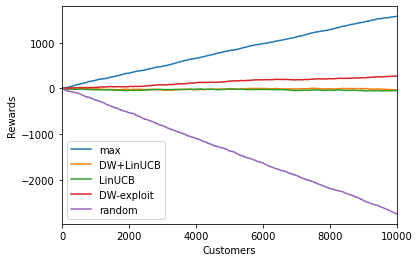

In [70]:
total_rewards_nn = [ 0. ]
for customer in range(customers):
    action = df.loc[customer, 'exp_best_action']
    if action == 0:
        total_rewards_nn.append(total_rewards_nn[-1] + df.loc[customer, 'reward_action_0'])
    elif action == 1:
        total_rewards_nn.append(total_rewards_nn[-1] + df.loc[customer, 'reward_action_1'])
    elif action == 2:
        total_rewards_nn.append(total_rewards_nn[-1] + df.loc[customer, 'reward_action_2'])

total_rewards_nn.pop(0)
            

plt.plot(lin2.max_total_rewards, label='max')
plt.plot(lin2.total_rewards, label='DW+LinUCB')
plt.plot(lin1.total_rewards, label='LinUCB')
plt.plot(total_rewards_nn, label='DW-exploit')
plt.plot(lin2.random_total_rewards, label='random')
plt.ylabel('Rewards')
plt.xlabel('Customers')
plt.xlim(0,10000)
plt.legend()

* Max - maximum possible rewards;
* random - rewards for randomly selected actions;
* LinUCB - rewards for actions selected based on the LinUCB policy trained with context [age, ARPU];
* DW-exploit - rewards for actions with maximum rewards predicted by the deep and wide model;
* DW+LinUCB - rewards for actions selected based on the LinUCB policy trained with rewards for each action predicted by the deep and wide model as context.

Note: the above results are for the TRAINING dataset!

# Generate a validation dataset

Procedure is the same as for the training dataset.

In [39]:
# Generate customer dataset

ages2 = [] # customer ages
ARPUs2 = [] # customer ARPUs
actions_taken2 = [] # actions taken by customers
rewards_received2 = [] # rewards received by customers
user_ids2 = [] # customer user IDs

contexts2 = [] # contexts provided for each customer
              # a context is a numpy array with dimensions (context_dim, 1) (column vectors)
rewards2 = []  # rewards that would have been received by each customer for each possible action
              # possible rewards are numpy arrays with dimensions (actions,)

for customer in range(customers):
    cust = get_customer() 
    customer_type = cust[0] - 1 # customer type
    contexts2.append( np.asarray(cust[1]).reshape((context_dim, 1)) ) # add context for customer to dataset
    # possible rewards for each customer are randomly sampled from the distributions
    # for each of the possible actions for the given customer type
    possible_rewards = np.zeros(actions)
    sampled_rewards = np.zeros(actions)
    for action in range(actions):
        mu = mean[customer_type][action]
        sigma = stdev[customer_type][action]
        possible_rewards[action] = np.random.normal(mu, sigma)
        sampled_rewards[action] = np.random.normal(mu, sigma)
        
    rewards2.append(possible_rewards) # add rewards received to dataset
    
    ages2.append(cust[1][0])
    ARPUs2.append(cust[1][1])
    user_ids2.append(cust[2])
    rewards_received2.append(possible_rewards[np.argmax(sampled_rewards)])
    actions_taken2.append(np.argmax(sampled_rewards))

In [71]:
lin1 = LinUCB(3, contexts2, rewards2, True)
lin1.offLinUCB()

In [46]:
df2 = pd.DataFrame()
df2['age'] = ages2
df2['ARPU'] = ARPUs2
df2['action'] = actions_taken2
df2['reward'] = rewards_received2
df2['user_id'] = user_ids2
df2.head()

,age,ARPU,action,reward,user_id
0,19,120.264202,0,-0.329401,8
1,25,85.714036,1,-0.756487,0
2,30,113.896804,1,-0.460426,16
3,24,84.820991,0,-0.296658,13
4,20,85.689865,2,-0.683336,6


In [47]:
num_columns = len(df2.columns.values)
num_rows = len(df2.index)

df2.insert(num_columns, "reward_action_0", [rewards2[i][0] for i in range(num_rows)])
df2.insert(num_columns+1, "reward_action_1", [rewards2[i][1] for i in range(num_rows)])
df2.insert(num_columns+2, "reward_action_2", [rewards2[i][2] for i in range(num_rows)])
df2.insert(num_columns+3, "best_action", [np.argmax(rewards2[i]) for i in range(num_rows)])
df2.head()

,age,ARPU,action,reward,user_id,reward_action_0,reward_action_1,reward_action_2,best_action
0,19,120.264202,0,-0.329401,8,-0.329401,-0.796613,-0.713136,0
1,25,85.714036,1,-0.756487,0,0.070005,-0.756487,-0.588962,0
2,30,113.896804,1,-0.460426,16,-0.367647,-0.460426,-0.551875,0
3,24,84.820991,0,-0.296658,13,-0.296658,-0.390640,-0.690444,0
4,20,85.689865,2,-0.683336,6,0.430440,-0.978866,-0.683336,0


In [48]:
num_columns = len(df2.columns.values)
num_rows = len(df2.index)
df2.insert(num_columns, "exp_reward_action_0", [0. for i in range(num_rows)])
df2.insert(num_columns+1, "exp_reward_action_1", [0. for i in range(num_rows)])
df2.insert(num_columns+2, "exp_reward_action_2", [0. for i in range(num_rows)])
df2.insert(num_columns+3, "exp_best_action", [0 for i in range(num_rows)])

## Context columns means and standard deviations for scaling the input
context_means = df2[context_cols].mean().values
context_std = df2[context_cols].std().values

for i in range(customers):
    test_context = (df2[context_cols].iloc[i].values - context_means) / context_std
    test_action = df[action_col].iloc[i].values
    test_reward = df[reward_col].iloc[i].values
    test_user_id = torch.tensor(df[user_id_col].iloc[i].values)

    exp = demo_model.expected_values(test_user_id, test_context)
    action = demo_model.action(test_user_id, test_context)

    df2.loc[i, 'exp_reward_action_0'] = exp[0].tolist()
    df2.loc[i, 'exp_reward_action_1'] = exp[1].tolist()
    df2.loc[i, 'exp_reward_action_2'] = exp[2].tolist()
    df2.loc[i, 'exp_best_action'] = action.tolist()
    
df2.head()

,age,ARPU,action,reward,user_id,reward_action_0,reward_action_1,reward_action_2,best_action,exp_reward_action_0,exp_reward_action_1,exp_reward_action_2,exp_best_action
0,19,120.264202,0,-0.329401,8,-0.329401,-0.796613,-0.713136,0,-0.224652,-0.737492,-0.570458,0
1,25,85.714036,1,-0.756487,0,0.070005,-0.756487,-0.588962,0,-0.251481,-0.684262,-0.567297,0
2,30,113.896804,1,-0.460426,16,-0.367647,-0.460426,-0.551875,0,-0.271880,-0.697430,-0.568323,0
3,24,84.820991,0,-0.296658,13,-0.296658,-0.390640,-0.690444,0,-0.213525,-0.655072,-0.496989,0
4,20,85.689865,2,-0.683336,6,0.430440,-0.978866,-0.683336,0,-0.213525,-0.655072,-0.496989,0


In [49]:
contexts2 = []
context = np.zeros((3,1))

for i in range(customers):
    context[0][0] = df2.loc[i, 'exp_reward_action_0']
    context[1][0] = df2.loc[i, 'exp_reward_action_1']
    context[2][0] = df2.loc[i, 'exp_reward_action_2']
    contexts2.append(context)

lin2 = LinUCB(3, contexts2, rewards2, True)
lin2.offLinUCB()

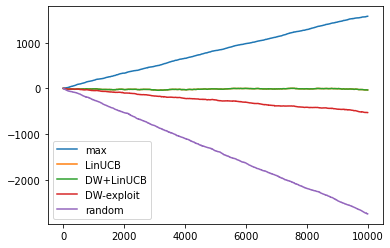

In [72]:
total_rewards_nn2 = [ 0. ]
for customer in range(customers):
    action = df2.loc[customer, 'exp_best_action']
    if action == 0:
        total_rewards_nn2.append(total_rewards_nn2[-1] + df2.loc[customer, 'reward_action_0'])
    elif action == 1:
        total_rewards_nn2.append(total_rewards_nn2[-1] + df2.loc[customer, 'reward_action_1'])
    elif action == 2:
        total_rewards_nn2.append(total_rewards_nn2[-1] + df2.loc[customer, 'reward_action_2'])

total_rewards_nn2.pop(0)
            
plt.plot(lin2.max_total_rewards, label='max')
plt.plot(lin1.total_rewards, label='LinUCB')
plt.plot(lin2.total_rewards, label='DW+LinUCB')
plt.plot(total_rewards_nn2, label='DW-exploit')
plt.plot(lin2.random_total_rewards, label='random')
plt.legend()

* Max - maximum possible rewards;
* random - rewards for randomly selected actions;
* LinUCB - rewards for actions selected based on the LinUCB policy trained with context [age, ARPU];
* DW-exploit - rewards for actions with maximum rewards predicted by the deep and wide model;
* DW+LinUCB - rewards for actions selected based on the LinUCB policy trained with rewards for each action predicted by the deep and wide model as context.

Note: the above results are for the VALIDATION dataset!

* Results for LinUCB and DW+LinUCB are almost identical.
* Results for LinUCB are worse than for DW-exploit for the TRAINING set, but better than for DW-exploit for the VALIDATION set (suggests overfitting)
* Both DW and LinUCB do much better than randomly picking actions, but still fall short of the optimal policy.